<a href="https://colab.research.google.com/github/jhermosillo/keyword_extraction/blob/main/API_TextRank_GFractal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Módulos necesarios

In [ ]:
# !pip install deplacy
# !pip install spacy

In [ ]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download es_core_news_sm

In [1]:
import pkg_resources,imp
imp.reload(pkg_resources)

<module 'pkg_resources' from 'C:\\Users\\Jorge Hermosillo\\anaconda3\\lib\\site-packages\\pkg_resources\\__init__.py'>

### Librerías necesarias para los algoritmos

In [2]:
from math import *
from math import sqrt
import string
import operator
import random
import pandas as pd
#librerias necesarias para text rank
from collections import OrderedDict
import numpy as np
import spacy

#Listado de STOPWORDS dependiendo del lenguaje
from spacy.lang.en.stop_words import STOP_WORDS
#from spacy.lang.es.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('es_core_news_sm')

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import InputLayer,Dense,Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.regularizers import l1,l1_l2,l2
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import RMSprop
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
    

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from scoring import *

# Algoritmo TextRank

In [37]:
class TextRank4Keyword():
    """Extract keywords from text"""

    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 100 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        keysw={}
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            keysw[key] =value
            if i > number:
                break
        return keysw
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight
        

# Algoritmo Grado de Fractalidad

In [38]:
#solamente se calcula el grado de fractalidad de las palabras que tengan mas de uno de frecuencia
def fractalidad(palabras,vocabulario,frec,dist):
    N=len(palabras)                                     #El número de tokens de todo el texto
    gf={}
    cajas_index=set()
    voc=[]                                             #la variable voc contendra cada sintagma con frecuencia mayor que 1, por que las otras palabras tendrán 0 de grado de fractaldiad
    for p in vocabulario:                              #Esto se puede hacer fuera del algoritmo, pero se incluye para evitar ese calculo innecesario 
        if(p not in voc):
            if(frec[p]>1):
                if(p not in STOP_WORDS):
                    if(len(p)>1):
                        voc.append(p)
    # print("Text size: ",N)
    # print("Vocabulary: ",len(voc))
    for p in voc:                                  
        rcajas=dist[p]
        M=frec[p]                                  
        dfw=0.0
        nsh=0.0
        for s in range(1,N+1):  
            noc=0                                       
            for e in rcajas:                       
                cajas_index.add(ceil(int(e)/s))    
            noc=len(cajas_index)                    
            cajas_index.clear()    
            ns=N/s
            if(M<=ns):
                nsh=M
            else:
                nsh=M/(1+(M-1)/(N-1)*(s-1)) 
            dfw=dfw+fabs(log(nsh/noc))
        gf[p]=dfw
    return gf    #regresamos un diccionario

In [39]:
def distribucion(palabras,vocabulario):
    N=len(palabras)
    ncajas=[]
    cajas={}
    frecuencias={}
    for p in vocabulario:
        ncajas.clear()
        i=0
        M=palabras.count(p)
        while(i<N):
            if(p == palabras[i]):
                ncajas.append(i+1)
            i=i+1
        frecuencias[p]=M
        cajas[p]=ncajas[:]
    return frecuencias,cajas

# Lectura de archivo de entrada

In [40]:
#Lectura de archivo para generación de vocabulario
def cargar_datos(filename):
    f=open(filename, "r") #tenemos que crear un directorio llamado InputData
    texto=f.read()
    #Pasar a minusculas
    texto=texto.lower()
    #Eliminar puntuación
    texto=texto.translate(str.maketrans('', '', string.punctuation))
    texto=texto.translate(str.maketrans('', '', '¿¡—“”0123456789’'))
    palabras=texto.split()
    textop=""
    #rearmamos el texto debido a ue existen carácteres especiales
    for w in palabras:
        textop=textop+w+' '
    return textop

DEFINICIÓN DEL NOMBRE DEL ARCHIVO A PROCESAR

Lectura de documentos

In [41]:
def lee_documento(filename='NULL',texto=''):
    if filename != 'NULL':
        texto=cargar_datos(filename)
    #obtenemos el vocabulario
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    return frec,dist,tokens,vocabulario,texto

# Ejecución de algoritmos y generación de archivos de salida

In [42]:
# lectura de documento de prueba
frec,dist,tokens,vocabulario,texto = lee_documento('data.txt')

## Grado de Fractalidad

In [43]:
#ejecución de algoritmo Grado de Fractalidad
def grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw=False,regresa_df=True,top_n=np.inf,escribe_arch=False):
    frac_x=fractalidad(tokens,vocabulario,frec,dist) 
    sorted_x = sorted(frac_x.items(), key=operator.itemgetter(1), reverse=True)
    # print('Time GF: '+str(elapsed_time))

    #Imprimir y guardar resultados de GF
    if regresa_df:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            df = [dato[0] for dato in df]
            by_MC=pd.DataFrame(df, columns=['word'])
        else:   
            by_MC=pd.DataFrame(df, columns=['word','frecuency','Degree_of_fractality','Combined_measure'])
        if escribe_arch:
            by_MC.to_csv('GF.csv')
    else:
        if top_n != np.inf:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x[:top_n]]
        else:
            df=[[t[0],frec[t[0]], t[1], t[1]*log10(frec[t[0]])] for t in sorted_x]
        #Ordenar resultados por medida combinada
        df.sort(key=lambda x: x[3],reverse=True)
        if regresa_kw==False:
            by_MC = [dato[0] for dato in df]
        else:
            by_MC = df
        if escribe_arch:
            print('\nNo se tiene implementada la escritura de archivo cuando regresa_df==False\n')
    return by_MC

def use_gf(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tokens=texto.split()
    vocabulario=[]
    for t in tokens:
        if(t not in vocabulario):
            vocabulario.append(t)
    #variables de procesamiento
    dist={}
    frec={}
    frec,dist=distribucion(tokens,vocabulario)
    df = grado_de_fractalidad(tokens,vocabulario,frec,dist,regresa_kw,regresa_df,top_n,escribe_arch)
    return df

df1 = use_gf(texto,regresa_kw=True,regresa_df=True,top_n=10)
df1

,word,frecuency,Degree_of_fractality,Combined_measure
0,latin,4,167.127394,100.620717
1,content,3,205.903714,98.241038
2,humour,3,163.880039,78.190650
3,injected,3,163.200270,77.866318
4,dummy,2,191.726724,57.715495
5,type,2,191.726724,57.715495
6,line,2,179.412131,54.008433
7,internet,2,175.612973,52.864773
8,reproduced,2,169.604962,51.056181
9,typesetting,2,166.080279,49.995146


## TextRank

In [44]:
#ejecución de algoritmo de TextRank
# start_time = time()
def use_TextRank(texto,regresa_kw=False,regresa_df=False,top_n=np.inf,escribe_arch=False):
    tr4w = TextRank4Keyword()
    tr4w.analyze(texto, candidate_pos = ['NOUN','PROPN'], window_size=4, lower=False)
    kwTR=tr4w.get_keywords(100)

    #Guardar resultados de TextRank
    if regresa_df:
        if top_n!=np.inf:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())[:top_n]
                dftr=pd.DataFrame(salida, columns=['word'])
        else:
            if regresa_kw==True:
                salida = [[key, kwTR[key]] for key in kwTR.keys()]
                dftr=pd.DataFrame(salida, columns=['word', 'Index'])
            else:
                salida = list(kwTR.keys())
                dftr=pd.DataFrame(salida, columns=['word'])
    else:
        if top_n!=np.inf:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()][:top_n]
            else:
                dftr = list(kwTR.keys())[:top_n]
        else:
            if regresa_kw==True:
                dftr = [[key, kwTR[key]] for key in kwTR.keys()]
            else:
                dftr = list(kwTR.keys())
        # elapsed_time = time() - start_time
        # print('Time TextRank: '+str(elapsed_time))
        if escribe_arch:
            dftr.to_csv('TextRank.csv')
    return dftr

dftr = use_TextRank(texto,top_n=10)
dftr

['ipsum',
 'lorem',
 'text',
 's',
 'versions',
 'words',
 'book',
 'bc',
 'latin',
 'humour']

# 20 Newsgroups

In [45]:
def preprocess_text(r,remove_STW=True,lemmatize=False):
    def check_STW(palabras):
        texto = [w for w in palabras \
                 if not w in STOP_WORDS and len(w)>2]
        return texto
    r1=r.cadena.str.translate(\
          str.maketrans('','',string.digits))\
          .str.translate(\
          str.maketrans('','',string.punctuation))\
          .str.replace('«','', regex=True)\
          .str.replace('»','', regex=True).str.replace('(','', regex=True)\
          .str.replace('\n',' ', regex=True)\
          .str.replace(')','', regex=True).str.strip().str.lower()
    if remove_STW:
        r1=r1.to_frame().applymap(lambda x : x.split()).applymap(check_STW).applymap(lambda x: ' '.join(x))
    if lemmatize:
        if isinstance(r1, pd.DataFrame):
            r1=r1.applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
        else:
            r1=r1.to_frame().applymap(lambda x : nlp(x)).applymap(lambda x: ' '.join([token.lemma_ for token in x]))        
    r.cadena = r1
    r=r.rename(columns={'cadena':'docs'})
    return r

In [46]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',remove=('headers', 'footers', 'quotes'))

from pprint import pprint
# pprint(list(newsgroups_train.target_names))

cats=list(newsgroups_train.target_names)
n = len(cats)//2
cats1=cats[:n]
cats2=cats[n:]
# print(cats)
print(cats1)
print(cats2)
categories = [cats1,cats2]

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball']
['rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [66]:
def process_20NG(categories,n=20,th=5,remove_STW=True,lemmatize=False):
    data=[]
    for i,cats in enumerate(categories):
        newsgroups_train = fetch_20newsgroups(subset='train', 
                                        remove=('headers', 'footers', 'quotes'),
                                        categories=cats)
        df = pd.DataFrame(newsgroups_train.data, columns=['cadena'])
        df['target'] = pd.Series(newsgroups_train.target+len(cats)*i)
        df = preprocess_text(df,remove_STW=remove_STW,lemmatize=lemmatize)
        df['TR'] = df.docs.apply(lambda x : use_TextRank(x,top_n=n))
        df['GF'] = df.docs.apply(lambda x : use_gf(x,top_n=n))
        df=df.drop(df[df.TR.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        df=df.drop(df[df.GF.apply(lambda x: len(x)<th)].index).reset_index(drop=True)
        data.append(df)
    lista=range(len(categories))
    newsgroups_data = data[0]
    if len(lista)>1:
        for j in lista[1:]:
            newsgroups_data = newsgroups_data.append(data[j],ignore_index=True)
    newsgroups_data = newsgroups_data.sample(frac=1).reset_index(drop=True)
    # newsgroups_data.to_csv('newsgroups_train_data.csv')
    return newsgroups_data

In [48]:
newsgroups_train_data = process_20NG(categories,n=100,remove_STW=True,lemmatize=True)
newsgroups_train_data

,docs,target,TR,GF
0,need help component bat diode know digikey new...,12,"[chip, digikey, newark, transistor, spdif, ord...","[chip, transistor, order, know, obtain, diode,..."
1,nsmca idea bit odd wall nsmca wilbur orville w...,14,"[wright, wall, bishop, boy, print, model, wind...","[wright, nsmca, wall, print, boy, bishop, odd]"
2,mdpumvbxnttqqgvgppvqqt mttbxomwmuplpdddddddq m...,2,"[maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, mimfqqaxaxax...","[maxaxaxaxaxaxaxaxaxaxaxaxaxaxax, end, maxaxax..."
3,jesus bear jew biblical account mother ancestr...,15,"[account, jesus, conversion, eunuch, christian...","[jesus, african, chapter, christian, semitic, ..."
4,offer scanner ship expense payment send person...,6,"[hour, check, payment, expense, way, scanner, ...","[way, find, scanner, payment, hour, check, exp..."
...,...,...,...,...
4929,come know national camera mile away agent gun ...,16,"[place, lawyer, fbi, arson, batf, witness, gun...","[place, yes, away, lawyer, witness, safe, fbi,..."
4930,nice article dss think answer david cruzuribe ...,15,"[book, dss, scroll, fitzmyer, response, sea, c...","[scroll, book, dss, sea, dead, question, respo..."
4931,mean consider absolutely impossible medium gui...,16,"[guncontrol, weapon, industry, ban, note, conc...","[carry, guncontrol, note, ban, industry, weapon]"
4932,let look effect inflation superstar salary rea...,9,"[inflation, salary, today, rate, chop, babe, p...","[average, salary, inflation, accurate, chop, n..."


In [37]:
print(np.unique(newsgroups_train_data.target))
print(newsgroups_train_data.GF.values[:5])
print(newsgroups_train_data.TR.values[:5])
df = newsgroups_train_data.copy()
df

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[list(['system', 'menu', 'time', 'use', 'wrap', 'bio', 'date', 'day', 'clock', 'indicator', 'lose', 'cause', 'midnight', 'increment', 'indication', 'kernel', 'update', 'read'])
 list(['tyre', 'ezekiel', 'satan', 'christian', 'israel', 'time', 'king', 'ruler'])
 list(['british', 'find', 'funny', 'come', 'vegas', 'las', 'act', 'trial', 'royal', 'ireland', 'prove', 'britain', 'thing', 'american', 'yes', 'way', 'country', 'england', 'think', 'pretty'])
 list(['chip', 'chance', 'clipper', 'checksum', 'internal', 'government', 'level', 'clearance', 'high'])
 list(['cell', 'trim', 'mesh', 'problem', 'loop', 'domain', 'help', 'segment', 'curve', 'bezier', 'inside', 'area'])]
[list(['day', 'bio', 'time', 'clock', 'system', 'wrap', 'menu', 'date', 'use', 'indicator', 'kernel', 'increment', 'midnight', 'tod', 'update', 'problem', 'indication', 'delete', 'reentrant', 'notice'])
 list(['tyre', 'ezekiel', 'satan', 'israel', 'king', 'ruler

,docs,target,TR,GF
0,stuff delete problem bio tod routine update bi...,3,"[day, bio, time, clock, system, wrap, menu, da...","[system, menu, time, use, wrap, bio, date, day..."
1,time ezekiel write israel apostacy mistaken ty...,0,"[tyre, ezekiel, satan, israel, king, ruler, bi...","[tyre, ezekiel, satan, christian, israel, time..."
2,think you re pretty hilarious love brit kiss r...,16,"[las, vegas, ireland, government, american, br...","[british, find, funny, come, vegas, las, act, ..."
3,will not work checksum key do not know registe...,11,"[chip, chance, clipper, level, clearance, gove...","[chip, chance, clipper, checksum, internal, go..."
4,problem hope guru help solve background proble...,1,"[cell, mesh, problem, help, segment, area, dom...","[cell, trim, mesh, problem, loop, domain, help..."
...,...,...,...,...
4929,thank read text distinct question arise guess ...,11,"[question, key, chip, realy, government, sessi...","[question, transmit, technical, key, turn, chi..."
4930,excellent automatic find subaru legacy switch ...,7,"[gear, throttle, driver, sport, mode, charge, ...","[gear, throttle, rev, know, low, switch, autom..."
4931,apr serbian genocide work god bingo there s oi...,15,"[work, god, thereisnogodthereisnogod, email, h...","[work, god, apr, serbian, genocide]"
4932,okay lets record straight livermore gas gun pr...,14,"[gun, projectile, plastic, chamber, fire, test...","[gun, projectile, work, test, plastic, laser, ..."


In [49]:
newsgroups_train_data.to_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')

## Lectura de archivo procesado

In [73]:
df = pd.read_pickle('newsgroups_train_data_sinSW_lemma_Top100.pickle')
df

,docs,target,TR,GF
0,need help component bat diode know digikey new...,12,"[chip, digikey, newark, transistor, spdif, ord...","[chip, transistor, order, know, obtain, diode,..."
1,nsmca idea bit odd wall nsmca wilbur orville w...,14,"[wright, wall, bishop, boy, print, model, wind...","[wright, nsmca, wall, print, boy, bishop, odd]"
2,jesus bear jew biblical account mother ancestr...,15,"[account, jesus, conversion, eunuch, christian...","[jesus, african, chapter, christian, semitic, ..."
3,let carry step suppose text key conclusive evi...,11,"[file, keyphrase, evidence, judge, copyright, ...","[keyphrase, judge, file, evidence, copyright, ..."
4,would not bet arab government generally do not...,17,"[jordan, israel, palestinean, war, lebanon, jo...","[arab, israel, jordan, israelis, palestinean, ..."
...,...,...,...,...
4387,come know national camera mile away agent gun ...,16,"[place, lawyer, fbi, arson, batf, witness, gun...","[place, yes, away, lawyer, witness, safe, fbi,..."
4388,nice article dss think answer david cruzuribe ...,15,"[book, dss, scroll, fitzmyer, response, sea, c...","[scroll, book, dss, sea, dead, question, respo..."
4389,mean consider absolutely impossible medium gui...,16,"[guncontrol, weapon, industry, ban, note, conc...","[carry, guncontrol, note, ban, industry, weapon]"
4390,let look effect inflation superstar salary rea...,9,"[inflation, salary, today, rate, chop, babe, p...","[average, salary, inflation, accurate, chop, n..."


In [ ]:
df = df.drop(df[df.TR.apply(lambda x: len(x)<20)].index).reset_index(drop=True)
df = df.drop(2).reset_index(drop=True)
df

# Word2vec

In [76]:
# import modules & set up logging
from gensim.models import Word2Vec as w2v
import gensim.downloader as api

def vocdf(df,vec_size=100):
    # obtain vocabulary word types 
    types=df['docs'].str.split(' ', expand=True).stack().unique()
    # Data Frame of vocabulary and word embeddings
    typesDF=pd.Series(types).to_frame()
    typesDF.rename(index=int,columns={0:'Palabra'},inplace=True)

    #Add Emebddings placeholders
    #Se necesita convertir el DF a diccionario
    #luego se agregan vectores de dimension N,
    #como registros nuevos del diccionario
    #para reconvertirlo en un DF de vuelta
    dico=typesDF.to_dict('records',into=OrderedDict)
    #Add real-valued embedding vectors
    for reg in dico:
        reg['W2V']=np.zeros(vec_size)
    typesDF=pd.DataFrame.from_dict(dico)
    typesDF.set_index('Palabra',inplace=True)
    return typesDF

def compute_embeddings(df,typesdf,vec_dim=100):
    #Nos quedamos con la columna que nos importa, la que contiene las cadenas
    docs = df["docs"].values.tolist()
    docs = [s.split() for s in docs]
    model = w2v(docs, min_count=1, vector_size=vec_dim)
    words = typesdf.index.values.tolist()
    for w in words:
        typesdf.at[w,'W2V'] = model.wv[w]
    return

typesDF = vocdf(df)
print(typesDF.iloc[0].W2V.shape)

compute_embeddings(df,typesDF)
print(typesDF.loc['sound'])
typesDF.to_pickle('typesDF_WE.pickle')
typesDF.head()
# model.wv['sound']
# model.wv.most_similar('good', topn=10) 

(100,)
W2V    [-1.381049, 0.54563457, 0.5914266, 0.57528454,...
Name: sound, dtype: object


,W2V
Palabra,
need,"[-0.60901845, 1.575926, 1.1810461, -0.09975571..."
help,"[-0.9882044, 1.4998451, 0.7599969, 0.57743037,..."
component,"[-0.40516067, 0.52279216, 0.25331777, -0.13157..."
bat,"[-0.1939912, 0.1985625, 0.16105084, -0.0640093..."
diode,"[-0.052956104, 0.057923045, 0.011956376, -0.04..."


In [77]:
typesDF = pd.read_pickle('typesDF_WE.pickle')
typesDF.head()

,W2V
Palabra,
need,"[-0.60901845, 1.575926, 1.1810461, -0.09975571..."
help,"[-0.9882044, 1.4998451, 0.7599969, 0.57743037,..."
component,"[-0.40516067, 0.52279216, 0.25331777, -0.13157..."
bat,"[-0.1939912, 0.1985625, 0.16105084, -0.0640093..."
diode,"[-0.052956104, 0.057923045, 0.011956376, -0.04..."


# Construye los arreglos de features

In [78]:
df['VTR'] = df.TR.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR
0,need help component bat diode know digikey new...,12,"[chip, digikey, newark, transistor, spdif, ord...","[chip, transistor, order, know, obtain, diode,...","[[-0.5426843, 1.9971958, 0.5782172, -1.2901381..."
1,nsmca idea bit odd wall nsmca wilbur orville w...,14,"[wright, wall, bishop, boy, print, model, wind...","[wright, nsmca, wall, print, boy, bishop, odd]","[[-0.06873636, 0.09378308, 0.09588813, -0.0476..."
2,jesus bear jew biblical account mother ancestr...,15,"[account, jesus, conversion, eunuch, christian...","[jesus, african, chapter, christian, semitic, ...","[[-0.24954411, 0.40481564, 0.6403858, 0.345843..."
3,let carry step suppose text key conclusive evi...,11,"[file, keyphrase, evidence, judge, copyright, ...","[keyphrase, judge, file, evidence, copyright, ...","[[-0.82989854, 2.37132, 1.1893111, -0.5492994,..."
4,would not bet arab government generally do not...,17,"[jordan, israel, palestinean, war, lebanon, jo...","[arab, israel, jordan, israelis, palestinean, ...","[[-0.11415116, 0.06679498, 0.06318931, -0.0723..."


In [79]:
df['VGF'] = df.GF.apply(lambda x: np.array([vec for word in x for vec in typesDF.loc[word]]))
df.head()

,docs,target,TR,GF,VTR,VGF
0,need help component bat diode know digikey new...,12,"[chip, digikey, newark, transistor, spdif, ord...","[chip, transistor, order, know, obtain, diode,...","[[-0.5426843, 1.9971958, 0.5782172, -1.2901381...","[[-0.5426843, 1.9971958, 0.5782172, -1.2901381..."
1,nsmca idea bit odd wall nsmca wilbur orville w...,14,"[wright, wall, bishop, boy, print, model, wind...","[wright, nsmca, wall, print, boy, bishop, odd]","[[-0.06873636, 0.09378308, 0.09588813, -0.0476...","[[-0.06873636, 0.09378308, 0.09588813, -0.0476..."
2,jesus bear jew biblical account mother ancestr...,15,"[account, jesus, conversion, eunuch, christian...","[jesus, african, chapter, christian, semitic, ...","[[-0.24954411, 0.40481564, 0.6403858, 0.345843...","[[-1.7453088, -0.10235943, 1.254299, 2.2950783..."
3,let carry step suppose text key conclusive evi...,11,"[file, keyphrase, evidence, judge, copyright, ...","[keyphrase, judge, file, evidence, copyright, ...","[[-0.82989854, 2.37132, 1.1893111, -0.5492994,...","[[0.0017788811, 0.067428075, 0.025578257, -0.0..."
4,would not bet arab government generally do not...,17,"[jordan, israel, palestinean, war, lebanon, jo...","[arab, israel, jordan, israelis, palestinean, ...","[[-0.11415116, 0.06679498, 0.06318931, -0.0723...","[[-0.13015018, -0.0031839807, 0.45344916, 0.21..."


In [80]:
df1 = df.copy()
df1['Palabras']=df1['TR'].apply(lambda x: len(x))
df1=df1.sort_values(by="Palabras")
df1

,docs,target,TR,GF,VTR,VGF,Palabras
0,need help component bat diode know digikey new...,12,"[chip, digikey, newark, transistor, spdif, ord...","[chip, transistor, order, know, obtain, diode,...","[[-0.5426843, 1.9971958, 0.5782172, -1.2901381...","[[-0.5426843, 1.9971958, 0.5782172, -1.2901381...",20
2839,lot problem keep hardware interrupt window do ...,2,"[disk, uart, write, cache, character, machine,...","[uart, buffer, disk, machine, cache, character...","[[-1.8115423, 1.5901834, 0.5824555, 0.06620693...","[[-0.23869966, 0.25501984, 0.09178423, -0.1324...",20
274,able pick adb cable computer wiring store addr...,4,"[cable, address, computer, adb, help, custom, ...","[cable, help, computer, adb, calgary, address]","[[-1.1662116, 0.74128515, 0.07862968, -0.38662...","[[-1.1662116, 0.74128515, 0.07862968, -0.38662...",20
2701,quick dirty way high current carrying capacity...,12,"[board, trace, copper, stamp, bus, fewofakind,...","[board, bare, copper, dirty, quick, trace]","[[-0.80731773, 0.88905823, 0.11643361, -0.5689...","[[-0.80731773, 0.88905823, 0.11643361, -0.5689...",20
2683,yes here run new chip trade little real techni...,3,"[machine, diskette, demo, people, load, mind, ...","[demo, machine, people, let, diskette]","[[-1.1432624, 1.1767498, 0.49381474, -0.019823...","[[-0.3239545, 0.49231756, 0.16489168, -0.14718...",20
...,...,...,...,...,...,...,...
437,ask echo question try contentious assume pope ...,15,"[pope, church, bishop, people, authority, fait...","[pope, catholic, new, command, infallibility, ...","[[-0.36022803, 0.13652354, 0.45180613, 0.43596...","[[-0.36022803, 0.13652354, 0.45180613, 0.43596...",100
3312,loose loose ill avoid spell flame person quest...,16,"[people, way, firearm, rkba, news, day, politi...","[shall, possible, die, criminal, firearm, avoi...","[[-0.5601787, 0.17047344, 1.1054351, 1.139872,...","[[-0.37948722, 0.23751476, 0.7050606, 0.506924...",100
2468,send believe got lose weekend accident moderat...,15,"[document, work, culture, test, time, nibley, ...","[document, culture, know, work, nibley, claim,...","[[-0.16309445, 0.78464544, 0.5911102, -0.07696...","[[-0.16309445, 0.78464544, 0.5911102, -0.07696...",100
2263,supreme court disagree state people term art r...,11,"[people, amendment, constitution, court, state...","[people, militia, jefferson, time, constitutio...","[[-0.5601787, 0.17047344, 1.1054351, 1.139872,...","[[-0.5601787, 0.17047344, 1.1054351, 1.139872,...",100


In [82]:
xx = df1.Palabras.values
cxx = sum(xx==20)
cxx

120

## Padding de arreglos

In [94]:
def paddingX(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    for i,x in enumerate(X):
        if x[0].shape[0] != n:
            fn = n - x[0].shape[0]
            padx = x[0].tolist()
            for j in range(fn):
                padx.append(pad_vec)
            X[i][0]=np.array(padx)
        else:
            X[i][0]=x[0]
    return

def padding(X,n,vec_dim):
    pad_vec = np.zeros(vec_dim)
    newX = []
    for x in X:
        if x.shape[0] < n:
            fn = n - x.shape[0]
            padx = x.tolist()
            for j in range(fn):
                padx.append(pad_vec)
            newX.append(padx)
        else:
            newX.append(x[:n])
    return np.array(newX)

In [95]:
X_VTR = df.VTR.values
X_VTR = X_VTR.reshape(X_VTR.shape[0],1)
y_VTR = df.target.values
y_VTR = y_VTR.reshape(y_VTR.shape[0],1)
VTR_train = np.hstack((X_VTR,y_VTR))
# padding(VTR_train,20,100)
VTR_train = pd.DataFrame(VTR_train,columns=['vec','target'])
VTR_train

,vec,target
0,"[[-0.5426843, 1.9971958, 0.5782172, -1.2901381...",12
1,"[[-0.06873636, 0.09378308, 0.09588813, -0.0476...",14
2,"[[-0.24954411, 0.40481564, 0.6403858, 0.345843...",15
3,"[[-0.82989854, 2.37132, 1.1893111, -0.5492994,...",11
4,"[[-0.11415116, 0.06679498, 0.06318931, -0.0723...",17
...,...,...
4387,"[[-0.62081, 0.61775136, 0.7579456, 0.50837225,...",16
4388,"[[-0.62457246, 0.6922159, 1.1643076, 1.1236067...",15
4389,"[[-0.023777463, 0.015647, 0.034111943, -0.0331...",16
4390,"[[-0.020462029, 0.01950279, 0.030296396, -0.00...",9


In [96]:
X_VGF = df.VTR.values
X_VGF = X_VGF.reshape(X_VGF.shape[0],1)
y_VGF = df.target.values
y_VGF = y_VGF.reshape(y_VGF.shape[0],1)
VGF_train = np.hstack((X_VGF,y_VGF))
# padding(VGF_train,20,100)
VGF_train = pd.DataFrame(VGF_train,columns=['vec','target'])
VGF_train

,vec,target
0,"[[-0.5426843, 1.9971958, 0.5782172, -1.2901381...",12
1,"[[-0.06873636, 0.09378308, 0.09588813, -0.0476...",14
2,"[[-0.24954411, 0.40481564, 0.6403858, 0.345843...",15
3,"[[-0.82989854, 2.37132, 1.1893111, -0.5492994,...",11
4,"[[-0.11415116, 0.06679498, 0.06318931, -0.0723...",17
...,...,...
4387,"[[-0.62081, 0.61775136, 0.7579456, 0.50837225,...",16
4388,"[[-0.62457246, 0.6922159, 1.1643076, 1.1236067...",15
4389,"[[-0.023777463, 0.015647, 0.034111943, -0.0331...",16
4390,"[[-0.020462029, 0.01950279, 0.030296396, -0.00...",9


# Setup de datos para clasificación

In [97]:
VTR_val = VTR_train.sample(frac=0.1)
VTR_train = VTR_train.drop(labels=VTR_val.index)

In [98]:
X_VTR_train = VTR_train.vec.values
X_VTR_train = padding(X_VTR_train,50,100)
print(X_VTR_train.shape)
y_VTR_train = VTR_train.target.values
print(y_VTR_train.shape)

X_VTR_val = VTR_val.vec.values
X_VTR_val = padding(X_VTR_val,50,100)
print(X_VTR_val.shape)
y_VTR_val = VTR_val.target.values
print(y_VTR_val.shape)

(3953, 50, 100)
(3953,)
(439, 50, 100)
(439,)


In [99]:
VGF_val = VGF_train.sample(frac=0.1)
VGF_train = VGF_train.drop(labels=VGF_val.index)

In [101]:
X_VGF_train = VGF_train.vec.values
X_VGF_train = padding(X_VGF_train,50,100)
print(X_VGF_train.shape)
y_VGF_train = VGF_train.target.values
print(y_VGF_train.shape)

X_VGF_val = VGF_val.vec.values
X_VGF_val = padding(X_VGF_val,50,100)
print(X_VGF_val.shape)
y_VGF_val = VGF_val.target.values
print(y_VGF_val.shape)

(3953, 50, 100)
(3953,)
(439, 50, 100)
(439,)


In [102]:
np.save('X_VTR_train.npy', X_VTR_train)
np.save('y_VTR_train.npy', y_VTR_train)
np.save('X_VTR_val.npy', X_VTR_val)
np.save('y_VTR_val.npy', y_VTR_val)

np.save('X_VGF_train.npy', X_VGF_train)
np.save('y_VGF_train.npy', y_VGF_train)
np.save('X_VGF_val.npy', X_VGF_val)
np.save('y_VGF_val.npy', y_VGF_val)

## Lee matrices de entrenamiento (Top 20)

In [4]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)

In [103]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)

print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

(3953, 50, 100) (3953,)
(3953, 50, 100) (3953,)
(439, 50, 100) (439,)
(439, 50, 100) (439,)


In [104]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)
X_VGF_val = X_VGF_val.astype('float32')

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

(3953, 50, 100, 1)
(3953,)
(3953, 50, 100, 1)
(3953,)


# Clasificación usando CNN

In [105]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(128, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  50 x 100
Shape before one-hot encoding:  (3953,)
Shape after one-hot encoding:  (3953, 20)
Epoch 1/100
124/124 [==============================] - 52s 411ms/step - loss: 71.8960 - accuracy: 0.2350 - val_loss: 38.2247 - val_accuracy: 0.1412
Epoch 2/100
124/124 [==============================] - 50s 402ms/step - loss: 32.7895 - accuracy: 0.3013 - val_loss: 30.3204 - val_accuracy: 0.2005
Epoch 3/100
124/124 [==============================] - 49s 398ms/step - loss: 27.5879 - accuracy: 0.3380 - val_loss: 26.6878 - val_accuracy: 0.1800
Epoch 4/100
124/124 [==============================] - 48s 389ms/step - loss: 25.3978 - accuracy: 0.3438 - val_loss: 25.8251 - val_accuracy: 0.1708
Epoch 5/100
124/124 [==============================] - 46s 372ms/step - loss: 24.4113 - accuracy: 0.3552 - val_loss: 24.5453 - val_accuracy: 0.2870
Epoch 6/100
124/124 [==============================] - 47s 378ms/step - loss: 23.4975 - accuracy: 0.3744 - val_loss: 24.2048 - val_accuracy: 0.2073


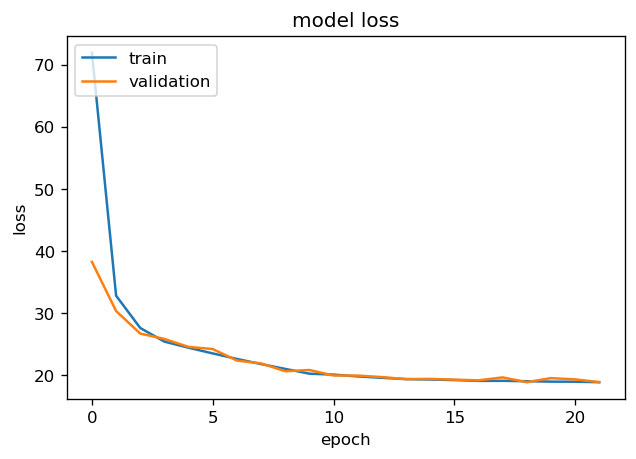

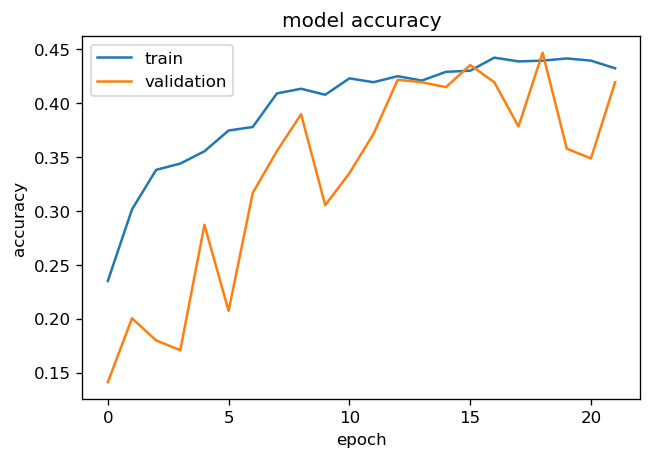

In [106]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [107]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(128, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  50 x 100
Shape before one-hot encoding:  (3953,)
Shape after one-hot encoding:  (3953, 20)
Epoch 1/100
124/124 [==============================] - 47s 372ms/step - loss: 71.7401 - accuracy: 0.2327 - val_loss: 37.9767 - val_accuracy: 0.1298
Epoch 2/100
124/124 [==============================] - 45s 361ms/step - loss: 32.6063 - accuracy: 0.3076 - val_loss: 29.8230 - val_accuracy: 0.2005
Epoch 3/100
124/124 [==============================] - 43s 351ms/step - loss: 27.3407 - accuracy: 0.3299 - val_loss: 26.6441 - val_accuracy: 0.1800
Epoch 4/100
124/124 [==============================] - 43s 347ms/step - loss: 24.9848 - accuracy: 0.3478 - val_loss: 24.7905 - val_accuracy: 0.2096
Epoch 5/100
124/124 [==============================] - 48s 392ms/step - loss: 23.8563 - accuracy: 0.3559 - val_loss: 23.5646 - val_accuracy: 0.2984
Epoch 6/100
124/124 [==============================] - 48s 390ms/step - loss: 23.1380 - accuracy: 0.3693 - val_loss: 23.1238 - val_accuracy: 0.2688


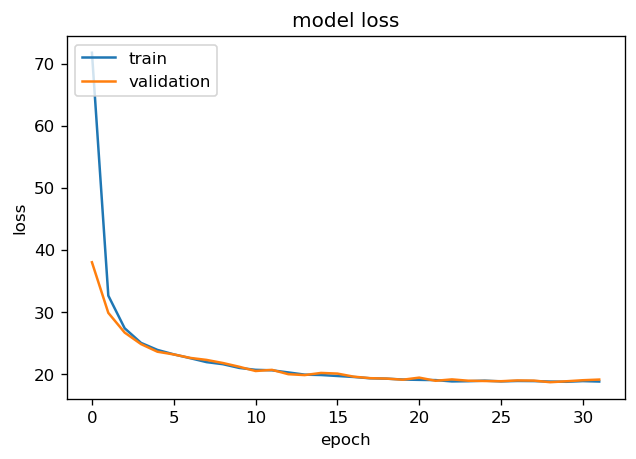

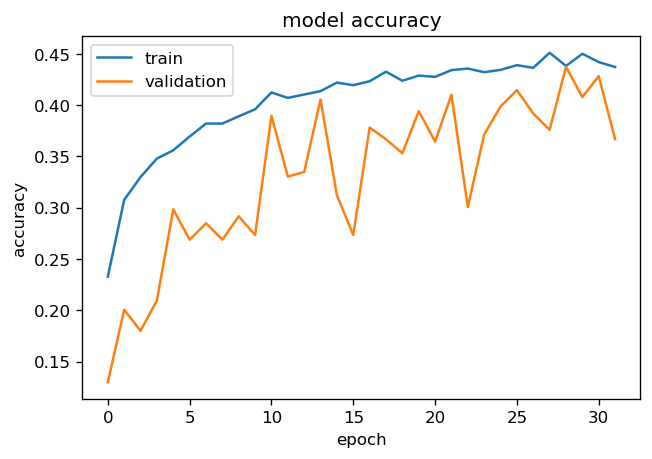

In [108]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Lee matrices de entrenamiento (Top 5)

In [4]:
X_VTR_train = np.load('X_VTR_train.npy', allow_pickle=True)
y_VTR_train = np.load('y_VTR_train.npy', allow_pickle=True)
X_VTR_val = np.load('X_VTR_val.npy', allow_pickle=True)
y_VTR_val = np.load('y_VTR_val.npy', allow_pickle=True)

X_VGF_train = np.load('X_VGF_train.npy', allow_pickle=True)
y_VGF_train = np.load('y_VGF_train.npy', allow_pickle=True)
X_VGF_val = np.load('X_VGF_val.npy', allow_pickle=True)
y_VGF_val = np.load('y_VGF_val.npy', allow_pickle=True)

In [5]:
print(X_VTR_train.shape, y_VTR_train.shape)
print(X_VGF_train.shape, y_VGF_train.shape)

print(X_VTR_val.shape, y_VTR_val.shape)
print(X_VGF_val.shape, y_VGF_val.shape)

(4441, 20, 100) (4441,)
(4441, 20, 100) (4441,)
(493, 20, 100) (493,)
(493, 20, 100) (493,)


In [5]:

X_VTR_train = X_VTR_train.reshape(X_VTR_train.shape[0], X_VTR_train.shape[1], X_VTR_train.shape[2], 1)[:,:5,:,:]
X_VTR_train = X_VTR_train.astype('float32')

X_VGF_train = X_VGF_train.reshape(X_VGF_train.shape[0], X_VGF_train.shape[1], X_VGF_train.shape[2], 1)[:,:5,:,:]
X_VGF_train = X_VGF_train.astype('float32')

X_VTR_val = X_VTR_val.reshape(X_VTR_val.shape[0], X_VTR_val.shape[1], X_VTR_val.shape[2], 1)[:,:5,:,:]
X_VTR_val = X_VTR_val.astype('float32')

X_VGF_val = X_VGF_val.reshape(X_VGF_val.shape[0], X_VGF_val.shape[1], X_VGF_val.shape[2], 1)[:,:5,:,:]
X_VGF_val = X_VGF_val.astype('float32')

print(X_VTR_train.shape)
print(y_VTR_train.shape)

print(X_VGF_train.shape)
print(y_VGF_train.shape)

(4441, 5, 100, 1)
(4441,)
(4441, 5, 100, 1)
(4441,)


# Clasificación usando CNN

In [17]:
# "images" sizes
X_train = X_VTR_train.copy()
X_val = X_VTR_val.copy()
y_train = y_VTR_train.copy()
y_val = y_VTR_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(100, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
# model.add(Dense(64, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
# model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  5 x 100
Shape before one-hot encoding:  (4441,)
Shape after one-hot encoding:  (4441, 20)
Epoch 1/100
139/139 [==============================] - 4s 21ms/step - loss: 18.3894 - accuracy: 0.3011 - val_loss: 6.3190 - val_accuracy: 0.2698
Epoch 2/100
139/139 [==============================] - 3s 20ms/step - loss: 5.1692 - accuracy: 0.3236 - val_loss: 5.0877 - val_accuracy: 0.2495
Epoch 3/100
139/139 [==============================] - 3s 20ms/step - loss: 4.4312 - accuracy: 0.3391 - val_loss: 4.3520 - val_accuracy: 0.3367
Epoch 4/100
139/139 [==============================] - 3s 20ms/step - loss: 4.1790 - accuracy: 0.3447 - val_loss: 4.1222 - val_accuracy: 0.3651
Epoch 5/100
139/139 [==============================] - 3s 20ms/step - loss: 4.0281 - accuracy: 0.3479 - val_loss: 3.9443 - val_accuracy: 0.3448
Epoch 6/100
139/139 [==============================] - 3s 20ms/step - loss: 3.9518 - accuracy: 0.3697 - val_loss: 4.0089 - val_accuracy: 0.3529
Epoch 7/100
139/139 [===

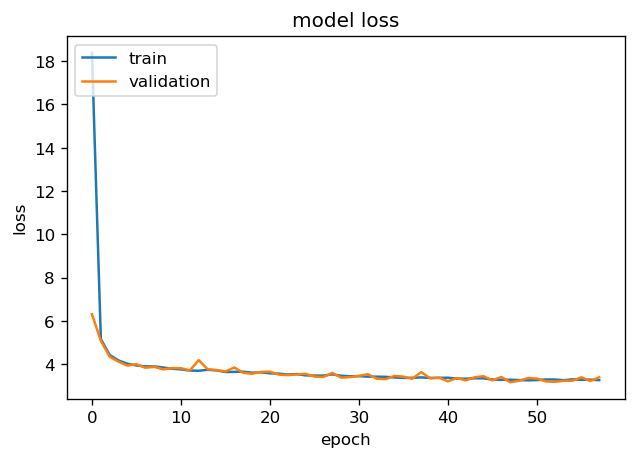

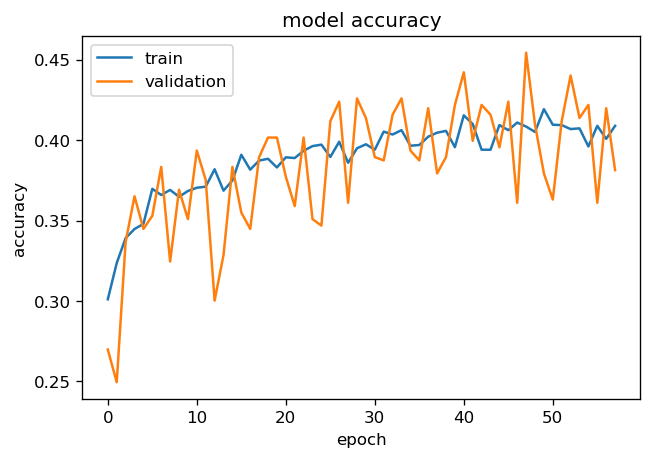

In [18]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
# "images" sizes
X_train = X_VGF_train.copy()
X_val = X_VGF_val.copy()
y_train = y_VGF_train.copy()
y_val = y_VGF_val.copy()

n1 = X_train.shape[1]
n2 = X_train.shape[2]

print("Las imágenes son de ",n1,"x",n2)

# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

# normalizing the data to help with the training
# X_train /= 255
# X_test /= 255

# one-hot encoding using keras' numpy-related utilities
n_classes = 20
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
# Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)


model = Sequential()
# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='leaky_relu', input_shape=(n1,n2,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(128, activation='leaky_relu',kernel_regularizer=l1_l2(l1=0.01,l2=0.001)))
model.add(BatchNormalization())
model.add(Dense(64, activation='leaky_relu'))
model.add(BatchNormalization())
# output layer
model.add(Dense(20, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model 

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, validation_data=(X_val, Y_val)
            ,callbacks=[early_callback])

# score = model.evaluate(X_test, Y_test)

Las imágenes son de  5 x 100
Shape before one-hot encoding:  (4441,)
Shape after one-hot encoding:  (4441, 20)
Epoch 1/100
139/139 [==============================] - 4s 25ms/step - loss: 22.4791 - accuracy: 0.2783 - val_loss: 7.2823 - val_accuracy: 0.2394
Epoch 2/100
139/139 [==============================] - 3s 24ms/step - loss: 6.2283 - accuracy: 0.3312 - val_loss: 6.1915 - val_accuracy: 0.2069
Epoch 3/100
139/139 [==============================] - 3s 24ms/step - loss: 5.4495 - accuracy: 0.3339 - val_loss: 5.3463 - val_accuracy: 0.2252
Epoch 4/100
139/139 [==============================] - 3s 24ms/step - loss: 4.9949 - accuracy: 0.3389 - val_loss: 4.9528 - val_accuracy: 0.3793
Epoch 5/100
139/139 [==============================] - 3s 24ms/step - loss: 4.7781 - accuracy: 0.3517 - val_loss: 4.9046 - val_accuracy: 0.3286
Epoch 6/100
139/139 [==============================] - 3s 24ms/step - loss: 4.6080 - accuracy: 0.3614 - val_loss: 4.4019 - val_accuracy: 0.3550
Epoch 7/100
139/139 [===

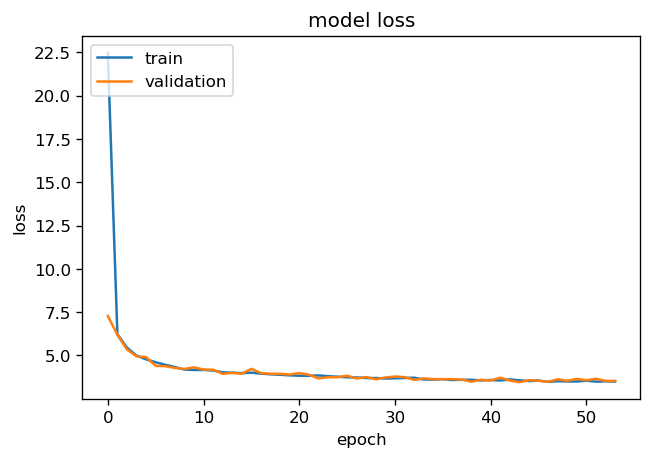

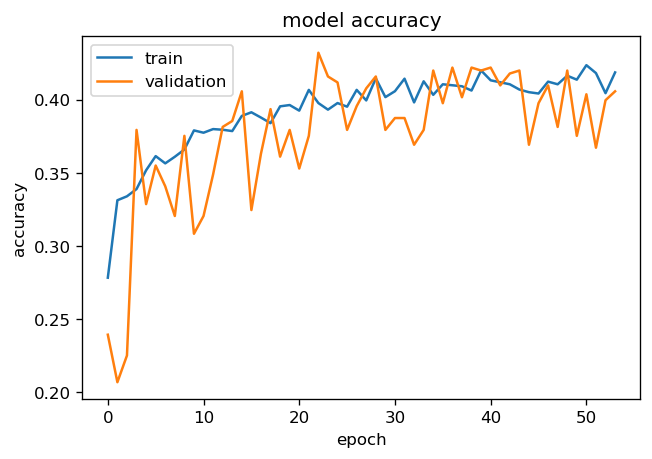

In [22]:
# print ('Test loss:', round(score[0], 3))
# print ('Test accuracy:', round(score[1]*100, 2),'%')
plt.figure(dpi=120)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(dpi=120)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()